# Positive samples for the dataset

## Extracting relevant information from the dataset

In [1]:
import pandas as pd
import numpy as np
import pydicom
import png
import math
from PIL import Image
from pathlib import Path
import boto3
import matplotlib.pyplot as plt
from collections import Counter

data_path = '/home/szelesteya/projects/EMBED_Open_Data/'
tables_path = data_path + 'tables/'
image_root_path = '/media/szelesteya/F824D4D024D492CC/EMBED-images/'
image_dcm_path = image_root_path + 'dicom-positive/'
image_png_path = image_root_path + 'positive'

In [2]:
# Import Legends which describe clinical information's labeling
df_legends = pd.read_csv(tables_path + 'AWS_Open_Data_Clinical_Legend.csv')

# Keep relevant information that is about calcifications
df_calcs = df_legends[df_legends['Header in export'].isin(['calcfind'])][['Code',
                                                                          'Meaning']]

# Drop codes that are irrelevant
df_calcs_rel = df_calcs[~df_calcs['Code'].isin(['V','U','S','M'])]

# df_calcs_rel

In [3]:
cli_df = pd.read_csv(tables_path + 'EMBED_OpenData_clinical.csv', low_memory=False)

# Only keeping result BIRADS-1 and BIRADS-2 screenings
pos_cli_df = cli_df[((cli_df.calcfind.notna()) & 
                     (cli_df.calcfind.isin(df_calcs_rel['Code'])))][[  'Unnamed: 0',
                                                                       'empi_anon',
                                                                       'acc_anon',
                                                                       'side',
                                                                       'calcfind',
                                                                       'calcdistri',
                                                                       'otherfind',
                                                                       'numfind',
                                                                       'path_severity',
                                                                       'age_at_study',
                                                                       'ETHNICITY_DESC',
                                                                       'study_date_anon',
                                                                       'asses']]

# Rename columns to prepare for merge
pos_cli_df = pos_cli_df.rename(columns={'study_date_anon':'diag_study_date'})

In [4]:
# Reading image metadata
meta_df = (pd.read_csv(tables_path + 'EMBED_OpenData_metadata_reduced.csv', low_memory=False))
meta_red_df = meta_df[  (meta_df['ROI_coords'] != "()") &
                        (meta_df['FinalImageType'] == '2D') &                         
                        (meta_df['spot_mag'] != 1)][[  'empi_anon',
                                                                'acc_anon',
                                                                'ImageLateralityFinal',
                                                                'anon_dicom_path',
                                                                'study_date_anon',
                                                                'ViewPosition', 
                                                                'num_roi',
                                                                'ROI_coords',
                                                                'spot_mag']]

# Rename columns to prepare for merge
meta_red_ren_df = meta_red_df.rename(columns={'ImageLateralityFinal':'side'})

In [5]:
# Merging clinical information with medical ones
pos_full_df = pos_cli_df.merge(meta_red_ren_df, on=['empi_anon','acc_anon','side'])

# Generate paths for png extraction
pos_full_df['relative_dcm_path'] = pos_full_df['anon_dicom_path'].apply(lambda x: '/'.join(x.split('/')[5:]))

# Keeping relevant columns
pos_empi_df = pos_full_df[['empi_anon',
                           'acc_anon',
                           'side',
                           'asses',
                           'age_at_study',
                           'calcfind',
                           'calcdistri',
                           'otherfind',
                           'numfind',
                           'ViewPosition',
                           'num_roi',
                           'ROI_coords',
                           'ETHNICITY_DESC',
                           'study_date_anon',
                           'diag_study_date',
                           'relative_dcm_path',
                           'spot_mag']]

# Rename columns to be more consistent
pos_empi_df = pos_empi_df.rename(columns={'ETHNICITY_DESC':'eth_desc',
                                          'calcfind':'calc_find',
                                          'calcdistri':'calc_distrib',
                                          'otherfind':'other_find',                                          
                                          'ViewPosition':'view_pos',
                                          'numfind':'num_find'})


# Convert study date so it is easily interpreted by Python
pos_empi_df['diag_study_date'] = pd.to_datetime(pos_empi_df['diag_study_date'], errors='coerce', format= '%Y-%m-%d')
pos_empi_df['study_date_anon'] = pd.to_datetime(pos_empi_df['study_date_anon'], errors='coerce')

# Keeping only screening exams with less than 180 day differential between diagnosis date and last exam date (the diagnosis might be outdated on other circumstances)
pos_empi_df['diag_date_diff'] = pos_empi_df.diag_study_date - pos_empi_df.study_date_anon
pos_empi_rel_df= pos_empi_df.loc[(pos_empi_df.diag_date_diff.dt.days >= 0) & 
                                 (pos_empi_df.diag_date_diff.dt.days <= 180)]

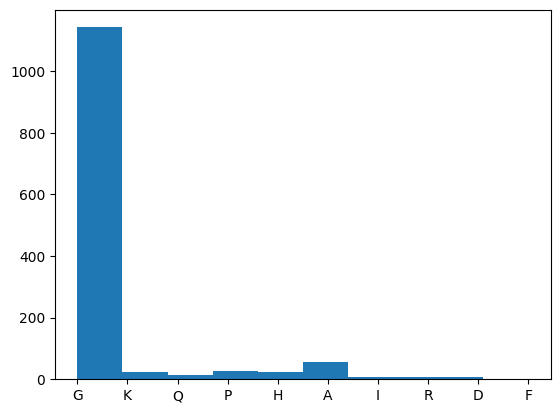

Counter({'G': 1142,
         'A': 56,
         'P': 27,
         'H': 25,
         'K': 22,
         'Q': 13,
         'R': 7,
         'I': 6,
         'D': 6,
         'F': 2})

In [6]:
bins = plt.hist(pos_empi_rel_df['calc_find'])
counts = Counter(pos_empi_rel_df['calc_find'])
# plt.text([(i + 0.5) for i in range(len(counts.values()))], str(counts.values()))
plt.savefig('calc_types')
plt.show()
counts

In [7]:
with open(data_path + 'positive_empirical.csv', 'w') as f:
    pos_empi_rel_df.to_csv(f)

## Pulling the DICOM images with a bash script

In [8]:
# Printing the path to file to read it in the bash script
with open(data_path + 'positive_path.csv', 'w') as f:
    pos_empi_rel_df.drop_duplicates(subset=['relative_dcm_path'])['relative_dcm_path'].to_csv(f, index=False)

In [9]:
%%bash -s "$image_dcm_path" "{data_path}positive_path.csv"

# Pulling dicom files with AWS CLI (Python API didn't work)
dcm_dest_path="$1"
dcm_paths="$2"
ind=$((1))

tail -n +2 $dcm_paths | while IFS= read -r line; do
    relative_path=$(echo "$line" | awk -v OFS='/' '{$1=$1; print}')
    dcm_name=$(echo "$relative_path" | cut -d '/' -f 3-)
               
    file="${dcm_dest_path}$relative_path"
    dir=$(dirname $file)
    mkdir $dir -p
    echo "$ind / 146"
                    
    if [ -f "$file" ]; then
        echo "File already present"
    else
        if [ -f "${dcm_dest_path}$dcm_name" ]; then
            dcm="${dcm_dest_path}$dcm_name"
            dir_dcm=$(dirname $dcm)
            echo "Moving file from ${dir_dcm}"
            mv "${dcm}" "${dcm_dest_path}$relative_path"
        else
            echo "Pulling file $file"
            aws s3 cp "s3://embed-dataset-open/images/$relative_path" "${file}" --profile my-dev-profile
        fi
    fi
    

    ind=$((ind+1))
    clear
done

mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


1 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/83470524/1.2.845.113975.3.59.1.50221084.20141110.1112012/1.2.840.113683.2750851774.1415170262.5404.2675/1.2.826.0.1.3680043.8.498.12681424261940133202438074551382227544.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


2 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/83470524/1.2.845.113975.3.59.1.50221084.20141110.1112012/1.2.842.113688.2750851775.1415170261.5405.2695/1.2.826.0.1.3680043.8.498.39167993503878102186225771580782440618.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


3 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/78265628/1.2.846.113971.3.66.1.51529504.20150736.1115118/1.2.840.113683.2750824974.1438237380.2336.34556/1.2.826.0.1.3680043.8.498.10735466440989741668586797439596379519.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


4 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/78265628/1.2.846.113971.3.66.1.51529504.20150736.1115118/1.2.842.113685.2750824975.1438237385.2336.34566/1.2.826.0.1.3680043.8.498.11876851440454397415965504044496659551.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


5 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/94908279/1.2.849.113979.3.66.1.51120217.20150510.1092161/1.2.840.113688.2229460970.1091.3608451148.121.1/1.2.826.0.1.3680043.8.498.79958064610726146381197861159911560926.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


6 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/94908279/1.2.849.113979.3.66.1.51120217.20150510.1092161/1.2.840.113681.2229460964.1086.3608451145.121.1/1.2.826.0.1.3680043.8.498.19258961318872992397570574856189137780.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


7 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/60601386/1.2.844.113970.3.57.1.51127641.20150509.1113255/1.2.840.113682.2750824975.1431066322.4273.35452/1.2.826.0.1.3680043.8.498.24180697105534965098627040458629805526.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


8 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/60601386/1.2.844.113970.3.57.1.51127641.20150509.1113255/1.2.849.113690.2750824984.1431066321.4273.35743/1.2.826.0.1.3680043.8.498.36248213127645964149101902603495503961.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


9 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/60601386/1.2.844.113970.3.57.1.51127641.20150509.1113255/1.2.841.113689.2750824983.1431066325.4276.35469/1.2.826.0.1.3680043.8.498.52343121588181425287350974339551290650.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


10 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/29788120/1.2.840.113970.3.62.1.50628540.20150136.1103053/1.2.848.113688.2750851772.1422429429.5402.1520/1.2.826.0.1.3680043.8.498.50858175597125137900123784301424179470.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


11 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/29788120/1.2.840.113970.3.62.1.50628540.20150136.1103053/1.2.843.113681.2750851781.1422429423.5403.1506/1.2.826.0.1.3680043.8.498.12818376455879486806001082146174324937.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


12 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/29788120/1.2.840.113970.3.62.1.50628540.20150136.1103053/1.2.847.113683.2750851780.1422429425.5407.1528/1.2.826.0.1.3680043.8.498.12136203195708960042931461343055597272.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


13 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/29788120/1.2.840.113970.3.62.1.50628540.20150136.1103053/1.2.846.113683.2750851781.1422429427.5403.1489/1.2.826.0.1.3680043.8.498.33789181795670273647921562617666242735.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


14 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/24011654/1.2.844.113976.3.57.1.51065345.20150434.1104233/1.2.843.113687.2750824981.1430116002.3877.30345/1.2.826.0.1.3680043.8.498.12417185415443114485157586373079920303.dcm


fatal error: 


Error while terminating subprocess (pid=12285): 


mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


15 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/24011654/1.2.844.113976.3.57.1.51065345.20150434.1104233/1.2.844.113690.2750824975.1430116003.3868.30332/1.2.826.0.1.3680043.8.498.42407552900750242592463889570165078607.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


16 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/16126842/1.2.849.113974.3.64.1.50860881.20150322.1/1.2.842.113681.2750824979.1426573502.4238.1890/1.2.826.0.1.3680043.8.498.99494044766262015518792026876797575818.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


17 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/16126842/1.2.849.113974.3.64.1.50860881.20150322.1/1.2.845.113681.2750824976.1426573508.4239.1885/1.2.826.0.1.3680043.8.498.85731612144854536020942685253485158800.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


18 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/94069255/1.2.843.113975.3.62.1.50919212.20150334.1153718/1.2.845.113688.2229460971.973.3604908694.354.1/1.2.826.0.1.3680043.8.498.20722942217240424527801115395178491018.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


19 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/94069255/1.2.843.113975.3.62.1.50919212.20150334.1153718/1.2.845.113683.2229460968.979.3604908693.355.1/1.2.826.0.1.3680043.8.498.74756296766062484705549123709386696394.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


20 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/74207244/1.2.842.113976.3.58.1.51176613.20150525.1082709/1.2.840.113689.2229460971.1033.3609488276.77.1/1.2.826.0.1.3680043.8.498.13258790419910520755331838040988323624.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


21 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/74207244/1.2.842.113976.3.58.1.51176613.20150525.1082709/1.2.842.113685.2229460968.1035.3609488270.70.1/1.2.826.0.1.3680043.8.498.53234707169310797867685004879432103713.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


22 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/74207244/1.2.842.113976.3.58.1.51176613.20150525.1082709/1.2.842.113683.2229460962.1030.3609488269.70.1/1.2.826.0.1.3680043.8.498.92410216857868285574628479090223047551.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


23 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/74207244/1.2.842.113976.3.58.1.51176613.20150525.1082709/1.2.841.113687.2229460968.1033.3609488278.72.1/1.2.826.0.1.3680043.8.498.10576957393567871897731868431544650425.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


24 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/44493032/1.2.846.113970.3.61.1.50785527.20150311.1110644/1.2.847.113681.2750824976.1425277114.5014.40035/1.2.826.0.1.3680043.8.498.10402472578892547757149878748361129728.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


25 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/44493032/1.2.846.113970.3.61.1.50785527.20150311.1110644/1.2.843.113689.2750824981.1425277114.5019.40050/1.2.826.0.1.3680043.8.498.95492353294254705602965176660803308744.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


26 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/61625861/1.2.848.113970.3.60.1.52182401.20151211.1134555/1.2.840.113689.2750824981.1449581645.4745.5525/1.2.826.0.1.3680043.8.498.97576092716424270931326768930859788407.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


27 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/61625861/1.2.848.113970.3.60.1.52182401.20151211.1134555/1.2.847.113682.2750824972.1449581645.4743.5534/1.2.826.0.1.3680043.8.498.36880561135068309428431878350846825012.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


28 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/15541424/1.2.844.113977.3.65.1.52221138.20151222.1145345/1.2.841.113683.2230564623.980.3627636222.260.1/1.2.826.0.1.3680043.8.498.55250709251722901116203108435658071554.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


29 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/15541424/1.2.844.113977.3.65.1.52221138.20151222.1145345/1.2.843.113686.2230564626.975.3627636220.269.1/1.2.826.0.1.3680043.8.498.99875443125466257716150171814626249222.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed
mkdir: cannot create directory ‘/media/szelesteya/F824D4D024D492CC’: Permission denied


30 / 146
Pulling file /media/szelesteya/F824D4D024D492CC/EMBED-images/dicom-positive/cohort_1/15541424/1.2.844.113977.3.65.1.52221138.20151222.1145345/1.2.840.113689.2230564624.975.3627636225.263.1/1.2.826.0.1.3680043.8.498.12432663822072829796124747439727192778.dcm


fatal error: Error when retrieving token from sso: Token has expired and refresh failed


31 / 146
File already present
32 / 146
File already present
33 / 146
File already present
34 / 146
File already present
35 / 146
File already present
36 / 146
File already present
37 / 146
File already present
38 / 146
File already present
39 / 146
File already present
40 / 146
File already present
41 / 146
File already present
42 / 146
File already present
43 / 146
File already present
44 / 146
File already present
45 / 146
File already present
46 / 146
File already present
47 / 146
File already present
48 / 146
File already present
49 / 146
File already present
50 / 146
File already present
51 / 146
File already present
52 / 146
File already present
53 / 146
File already present
54 / 146
File already present
55 / 146
File already present
56 / 146
File already present
57 / 146
File already present
58 / 146
File already present
59 / 146
File already present
60 / 146
File already present
61 / 146
File already present
62 / 146
File already present
63 / 146
File already present
64 / 146
F

### Converting the DICOM images to PNG

In [8]:
# Rescale the intensity of the image to get heterogene images with the bit depth of 14
def rescale_to_8bit(image_array):
    upper_percentile = np.percentile(image_array.flatten(), 98) # original_max = np.max(image_array)
    lower_percentile = np.percentile(image_array.flatten(), 2) # original_min = np.min(image_array)
    # max_on_14bit = 16383
    max = 255
    rescaled_array = (image_array - lower_percentile) / (upper_percentile - lower_percentile)
    rescaled_array[rescaled_array < 0] = 0
    rescaled_array[rescaled_array > 1] = 1
    # rescaled_array = np.round((image_array - original_min) / (original_max - original_min) * max_on_14bit).astype(int)
    return np.round(rescaled_array * 255).astype(np.uint8)

def generate_png_path(dcm_path):
    # Get new file name
    split_fn = dcm_path[:-4].split('/')
    new_fn = f"{split_fn[-1]}_conv.png"
    return image_path + new_fn

# Save DICOM pixel array as PNG
def save_dcm_image_as_png(image, png_filename, bitdepth=8):
    with open(png_filename, 'wb') as f:
        rescaled = rescale_to_8bit(image)
        writer = png.Writer(height=rescaled.shape[0], 
                            width=rescaled.shape[1], 
                            bitdepth=bitdepth, 
                            greyscale=True)
        writer.write(f, rescaled.tolist())

def generate_png_path(acc_anon, png_dir):
    # Get new file name
    new_fn = f"{acc_anon}_neg_conv.png"
    return f'{png_dir}/{new_fn}'

# Convert list of DICOMs to PNGs
def process_dcm_list(dcm_list, png_list):    
    for i, dcm_path in enumerate(dcm_list):    
        if not Path(png_list[i]).exists():
            print(f"Processing DICOM #{i}...")
            
            # Load DICOM
            dcm = pydicom.dcmread(dcm_path)
            img = dcm.pixel_array
            
            # Save PNG            
            save_dcm_image_as_png(img, png_list[i])

def extract_images(data_file_name, dcm_dir, png_dir):
    # Provide a list of DICOM paths and a target directory
    dcm_list = []
    df = pd.read_csv(data_file_name)
    
    for index, row in df.iterrows():
        path = dcm_dir  + row['relative_dcm_path']
        if Path(path).exists():
            dcm_list.append(path)
        
    # Insert png path
    df.loc[:,'png_path'] = df['acc_anon'].apply(lambda x: generate_png_path(x, png_dir))

    # Convert DICOMs
    process_dcm_list(dcm_list, df['png_path'])

    return df

In [9]:
pos_img_emp = extract_images(data_path + 'positive_empirical.csv', image_dcm_path, image_png_path)

with open(data_path + 'positive_empirical_png.csv', 'w') as f:
    (pos_img_emp).to_csv(f, index=False)

Processing DICOM #0...
Processing DICOM #1...
Processing DICOM #2...
Processing DICOM #6...
Processing DICOM #8...
Processing DICOM #9...
Processing DICOM #10...
Processing DICOM #11...
Processing DICOM #13...
Processing DICOM #17...
Processing DICOM #19...
Processing DICOM #20...
Processing DICOM #21...
Processing DICOM #23...
Processing DICOM #25...
Processing DICOM #28...
Processing DICOM #32...
Processing DICOM #34...
Processing DICOM #35...
Processing DICOM #37...
Processing DICOM #38...
Processing DICOM #42...
Processing DICOM #43...
Processing DICOM #46...
Processing DICOM #48...
Processing DICOM #50...
Processing DICOM #51...
Processing DICOM #52...
Processing DICOM #53...
Processing DICOM #55...
Processing DICOM #56...
Processing DICOM #57...
Processing DICOM #59...
Processing DICOM #61...
Processing DICOM #63...
Processing DICOM #65...
Processing DICOM #66...
Processing DICOM #68...
Processing DICOM #70...
Processing DICOM #71...
Processing DICOM #72...
Processing DICOM #73..